## Causal estimation

This notebook provides an attempt at causal estimation of the role of gender in wage inequalities. 
As a reminder, this dataset  - `Description des emplois salariés en 2021` is taken from the `Insee` website at the following link : <https://www.insee.fr/fr/statistiques/7651654#dictionnaire>.
We aim to study the effect of gender on the level of wages, depending on several variables.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiPolygon
from tqdm import tqdm
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode
init_notebook_mode(connected= True)
import plotly.express as px
import seaborn as sns
import scipy as sp

In [2]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import RepeatedKFold, cross_validate

`Warning` : This code should be run after the [import and formating notebook](test_import_données.ipynb).

In [3]:
base = pd.read_csv("INSEE_DATA_TREATED.csv")

/tmp/ipykernel_966/440333465.py:1: DtypeWarning:

Columns (1,2,4,25,32,33) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
base.columns

In [ ]:
target = ['WAGE']
numerical_columns = [
    #'DATDEB', 'DATFIN', #date début et fin de rémunération par rapport au 01/01
     'AGE', #age en années
    'DUREE', #durée de paie en jours
      'NBHEUR', 'NBHEUR_TOT', #nombre d'heures salariées total (quelle diff?)
    #'WAGE', #transformation of TRNNETO
    #'UNEMP' #transformation of TRALCHT
]

categorical_columns = [
    #'A6', 'A17', 'A38' #activité en nomenclature agrégrée
    'CPFD', #temps complet ou partiel
    #DEPR', 'DEPT', #département résidence et travail
    #'DOMEMPL', 'DOMEMPL_EM', #domaine de l'emploi et l'établissement d'affectation/employeur
    
    'FILT', #indic poste annexe 2 ou non-annexe 1 (seuils rémunération volume)
    #'REGR', 'REGT', #région de résidence et de travail
    'SEXE', #1 homme 2 femme
    'PCS', #PCS-ESE
    'TYP_EMPLOI', #ordinaire, apprenti, autre
    #'CONV_COLL', #convention collective
  
    #'TRNNETO', #rémunération nette globale en tranches -> à passer en numérique ?
    'TRALCHT', #total des indémnités de chômage, en tranches -> passage en numérique ?
    'TREFF', #tranche d'effectif : de 0 à 250+ postes
    'CONT_TRAV', #contrat de travail : APP apprentissage, TOA occasionnel ou à l'acte, TTP intérim, AUTre
    'CS', #CSP mais code plus simple 
    'AGE_TR', #age en tranches quadriennales
    'DATDEB_TR',
       'DATFIN_TR', #dates début et fin rémunération en tranches
    #'DUREE_TR', #durée de paie exprimée en jours en tranches mensuelles
    'DOMEMPL_EM_N', 'DOMEMPL_N', 'REGR_N',
       'REGT_N', 'CS_N', 'DEPR_N', 'DEPT_N','A38_N' #les variables renommées avec les labels correspondants aux codes
]

all_columns = numerical_columns + categorical_columns

## First method: a penalized linear model 

This step is useful to get a first broad idea of which covariates are important to predict wages.

First, we split the sample into a train and a test dataset. 
Only the train dataset will be used to fit the model.

In [ ]:
X = base[all_columns]
X.describe(include="all")

We modify the target variable (wage) by replacing the 0s with 1s that can be handled when transformed by a log, this allows us to avoid infinity values.

In [ ]:
base['TARGET'] = base[target]
base.loc[base['TARGET'] == 0, 'TARGET'] = 1
y = base['TARGET']
y.value_counts()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

The datasat contains categorical variables that cannot be included in a linear model if they are not coded as integers first. In addition, to avoid categorical features to be treated as ordered values, we need to one-hot-encode them.

We will do that with a pre-processor that:
- one-hot-encode the categorical columns
- rescale numerical columns.

In [ ]:
#preprocessor = make_column_transformer(
 #   (OneHotEncoder(drop="if_binary"), categorical_columns),
 #   (StandardScaler(), numerical_columns),
#)

We modify the preprocessing step to handle missing values.
We could have also dropped all rows with missing information.

In [ ]:
preprocessor = make_column_transformer(
    # For categorical columns: impute missing values with the most frequent value and apply OneHotEncoding
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop="if_binary")), categorical_columns),
    
    # For numerical columns: impute missing values with the median and apply StandardScaler
    (make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), numerical_columns)
)

In [ ]:
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
)

In [ ]:
model.fit(X_train, y_train)

We check the performance of the model by checking its predictions on the test set with the median absolute error.

In [ ]:
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} €/year",
    "MedAE on testing set": f"{mae_test:.2f} €/year",
}

In [ ]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model, small regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

In [ ]:
feature_names = model[:-1].get_feature_names_out()
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [ ]:
coefs_005=coefs[coefs["Coefficients importance"]>0.05]

In [ ]:
coefs_005.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [ ]:
coefs_minus005=coefs[coefs["Coefficients importance"]<-0.05]

coefs_minus005.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [ ]:
coefs

In [ ]:
plt.hist(model[1].regressor_.coef_,bins=model[1].regressor_.coef_.shape[0])

## First model : less variables

In [ ]:
target = ['WAGE']
numerical_columns = [
    #'DATDEB', 'DATFIN', #date début et fin de rémunération par rapport au 01/01
     'AGE', #age en années
    'DUREE', #durée de paie en jours
      #'NBHEUR', 
    'NBHEUR_TOT', #nombre d'heures salariées total (quelle diff?)
    #'WAGE', #transformation of TRNNETO
    #'UNEMP' #transformation of TRALCHT
]

categorical_columns = [
    #'A6', 'A17', 'A38' #activité en nomenclature agrégrée
    'CPFD', #temps complet ou partiel
    #DEPR', 'DEPT', #département résidence et travail
    #'DOMEMPL', 'DOMEMPL_EM', #domaine de l'emploi et l'établissement d'affectation/employeur
    
    'FILT', #indic poste annexe 2 ou non-annexe 1 (seuils rémunération volume)
    #'REGR', 'REGT', #région de résidence et de travail
    'SEXE', #1 homme 2 femme
    #'PCS', #PCS-ESE
    'TYP_EMPLOI', #ordinaire, apprenti, autre
    #'CONV_COLL', #convention collective
  
    #'TRNNETO', #rémunération nette globale en tranches -> à passer en numérique ?
    'TRALCHT', #total des indémnités de chômage, en tranches -> passage en numérique ?
    'TREFF', #tranche d'effectif : de 0 à 250+ postes
    'CONT_TRAV', #contrat de travail : APP apprentissage, TOA occasionnel ou à l'acte, TTP intérim, AUTre
    'CS', #CSP mais code plus simple 
    'AGE_TR', #age en tranches quadriennales
    'DATDEB_TR',
       'DATFIN_TR', #dates début et fin rémunération en tranches
    #'DUREE_TR', #durée de paie exprimée en jours en tranches mensuelles
    'DOMEMPL_EM_N', 'DOMEMPL_N', 'REGR_N',
       'REGT_N', 'CS_N', 
    #'DEPR_N', 'DEPT_N','A38_N' #les variables renommées avec les labels correspondants aux codes
]

all_columns = numerical_columns + categorical_columns

In [ ]:
X = base[all_columns]
X.describe(include="all")
base['TARGET'] = base[target]
base.loc[base['TARGET'] == 0, 'TARGET'] = 1
y = base['TARGET']
y.value_counts()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

We use the same model :

In [ ]:
preprocessor = make_column_transformer(
    # For categorical columns: impute missing values with the most frequent value and apply OneHotEncoding
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop="if_binary")), categorical_columns),
    
    # For numerical columns: impute missing values with the median and apply StandardScaler
    (make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), numerical_columns)
)

In [ ]:
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
)

In [ ]:
model.fit(X_train, y_train)

In [ ]:
feature_names = model[:-1].get_feature_names_out()
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

## Second model: Lasso

In [4]:
from sklearn.linear_model import LassoCV


In [13]:
target = ['WAGE']
numerical_columns = [
    'DATDEB', 'DATFIN', #date début et fin de rémunération par rapport au 01/01
     'AGE', #age en années
    'DUREE', #durée de paie en jours
      'NBHEUR', 'NBHEUR_TOT', #nombre d'heures salariées total (quelle diff?)
    #'WAGE', #transformation of TRNNETO
    #'UNEMP' #transformation of TRALCHT
]

categorical_columns = [
    #'A6', 'A17', 'A38' #activité en nomenclature agrégrée
    'CPFD', #temps complet ou partiel
    #DEPR', 'DEPT', #département résidence et travail
    #'DOMEMPL', 'DOMEMPL_EM', #domaine de l'emploi et l'établissement d'affectation/employeur
    
    'FILT', #indic poste annexe 2 ou non-annexe 1 (seuils rémunération volume)
    #'REGR', 'REGT', #région de résidence et de travail
    'SEXE', #1 homme 2 femme
    #'PCS', #PCS-ESE
    'TYP_EMPLOI', #ordinaire, apprenti, autre
    #'CONV_COLL', #convention collective
  
    #'TRNNETO', #rémunération nette globale en tranches -> à passer en numérique ?
    'TRALCHT', #total des indémnités de chômage, en tranches -> passage en numérique ?
    'TREFF', #tranche d'effectif : de 0 à 250+ postes
    'CONT_TRAV', #contrat de travail : APP apprentissage, TOA occasionnel ou à l'acte, TTP intérim, AUTre
    #'CS', #CSP mais code plus simple 
    'AGE_TR', #age en tranches quadriennales
    #'DATDEB_TR','DATFIN_TR', #dates début et fin rémunération en tranches
    #'DUREE_TR', #durée de paie exprimée en jours en tranches mensuelles
    'DOMEMPL_EM_N', 'DOMEMPL_N', 
    'REGR_N', 'REGT_N', 
    'CS_N', 'DEPR_N', 'DEPT_N','A38_N' #les variables renommées avec les labels correspondants aux codes
]

all_columns = numerical_columns + categorical_columns

In [14]:
X = base[all_columns]
X.describe(include="all")
base['TARGET'] = base[target]
base.loc[base['TARGET'] == 0, 'TARGET'] = 1
y = base['TARGET']
y.value_counts()

TARGET
30000    172700
18000    163694
20000    162269
22000    149751
16000    144555
50000    134496
24000    132108
14000    125933
4000     120161
8000     118031
40000    114143
26000    113143
10000    111997
6000     111967
12000    109501
35000    108381
28000     95396
2000      73460
3000      67358
1500      39083
1000      30022
500        4794
200         592
1           240
Name: count, dtype: int64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [16]:
preprocessor = make_column_transformer(
    # For categorical columns: impute missing values with the most frequent value and apply OneHotEncoding
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop="if_binary")), categorical_columns),
    
    # For numerical columns: impute missing values with the median and apply StandardScaler
    (make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), numerical_columns)
)

We fit a Lasso model with cross-validation to choose the alpha.

# DOES NOT WORK: TOO LONG

In [22]:
alphas = np.logspace(-5, 5, 11)
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(alphas=alphas, max_iter=100, n_jobs=-1),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)

In [23]:
model.fit(X_train, y_train)

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.737032095079485, tolerance: 22.304050809269995

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.510081462667586, tolerance: 22.328541517180028

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.76690319860427, tolerance: 22.293104531769277

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.10584676451981, tolerance: 22

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['CPFD', 'FILT', 'SEXE',
                                                   'TYP_EMPLOI', 'TRALCHT',
                                                   'TREFF', 'CONT_TRAV',
                                                   'AGE_TR', 'DOMEMPL_EM_N',
                                                   'DOMEMPL_N', 'REGR_N',
                                                   'REGT_N', 'CS_N', 'DEPR_N',
                                                   'DEPT_...
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['DATDEB', 'DATFIN', 'AGE',
                                                   'DUREE', 'NBHEUR',
                                                   'NBHEUR_TOT'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=LassoCV(alphas=array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05]),
                                                              max_iter=100,
                                                              n_jobs=-1)))])

The fitting step of this model is very long due to the size of the dataset. It took 14 minutes to crossvalidate, and we do not have convergence for every alpha tested. We tried to increase the number of iterations but the time to converge was too high. 

The alpha selected by this crossvalidation is: 

In [27]:
alpha_cv_lasso = model[-1].regressor_.alpha_
alpha_cv_lasso

np.float64(9.999999999999999e-06)

We try to visualise the magnitude of the coefficients of the different variables but there are too many for the graph to be understandable.

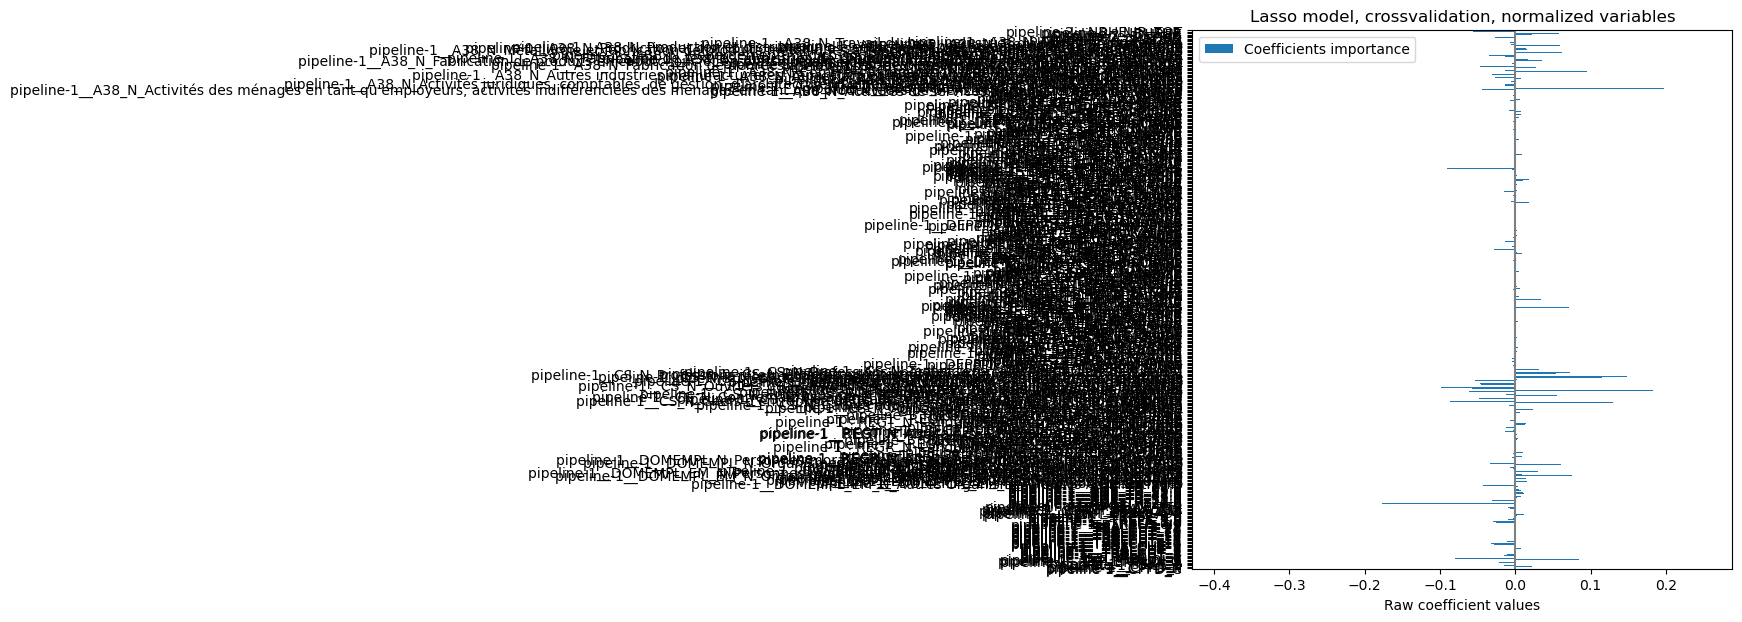

In [25]:
feature_names = model[:-1].get_feature_names_out()
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Lasso model, crossvalidation, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In order to understand how many variables were penalized by the Lasso selection, we make a histogram of the values of the coefficients.
122 coefficients out of 270 were put to zero. There was a significant selection.

Text(0.5, 1.0, 'Distribution of the Lasso coefficients')

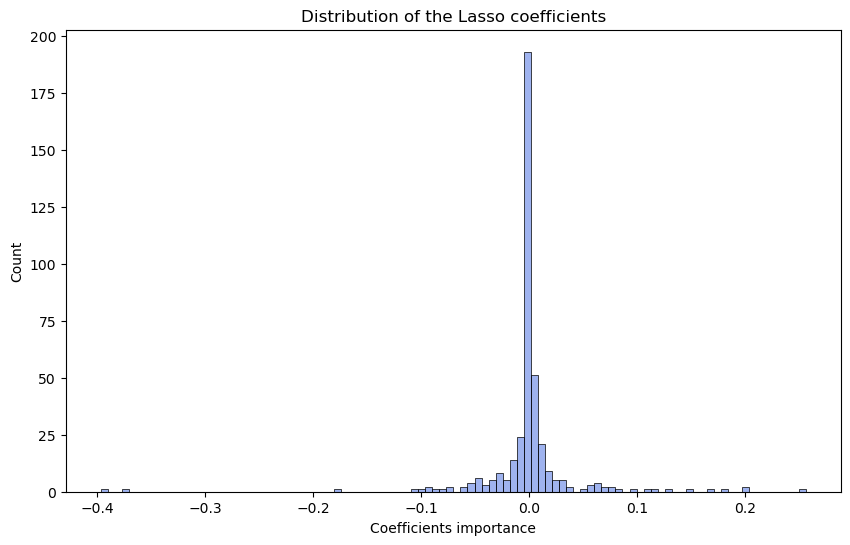

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(coefs["Coefficients importance"], bins=100, color = 'royalblue', alpha = 0.5)
plt.title('Distribution of the Lasso coefficients')

In [28]:
coefs["Coefficients importance"].value_counts()

Coefficients importance
 0.000000    122
 0.000210      1
-0.002881      1
-0.005434      1
 0.017654      1
            ... 
-0.000393      1
-0.001792      1
 0.010487      1
-0.007109      1
-0.019523      1
Name: count, Length: 270, dtype: int64

Now, we select and plot the 15 greatest coefficients and the coefficient of the variable Sex in order to understand which 

In [29]:
# Get the absolute value of coefficients
coefs["abs_coefs"] = coefs["Coefficients importance"].abs()

# Sort the coefficients by absolute value in descending order
coefs_sorted = coefs.sort_values(by='abs_coefs', ascending=False)

# Select the top 10 greatest coefficients in absolute value
top_10 = coefs_sorted.head(15)

specific_row = coefs[coefs.index == 'pipeline-1__SEXE_2']
top_10_with_specific_row = pd.concat([top_10, specific_row], axis=0)

# Re-sort if needed (optional), in case the specific row's coefficient value was smaller than the current top 10
top_10_with_specific_row = top_10_with_specific_row.sort_values(by='abs_coefs', ascending=False)
top_10_with_specific_row

,Coefficients importance,abs_coefs
pipeline-1__FILT_2,-0.396156,0.396156
pipeline-1__DOMEMPL_EM_N_Particuliers Employeurs,-0.370847,0.370847
pipeline-2__NBHEUR_TOT,0.255854,0.255854
pipeline-1__CS_N_Cadres administratifs et commerciaux d'entreprises,0.200859,0.200859
"pipeline-1__A38_N_Activités des ménages en tant qu'employeurs, activités indifférenciées des ménages en tant que producteurs de biens et services pour usage propre",0.197706,0.197706
pipeline-1__CS_N_Ingénieurs et cadres techniques d'entreprises,0.183354,0.183354
pipeline-1__AGE_TR_19.0,-0.177655,0.177655
pipeline-1__CS_N_Professions libérales (exercées sous statut de salarié),0.166985,0.166985
"pipeline-1__CS_N_Professions de l'information, des arts et des spectacles",0.148611,0.148611
pipeline-1__CS_N_Cadres de la fonction publique,0.130347,0.130347


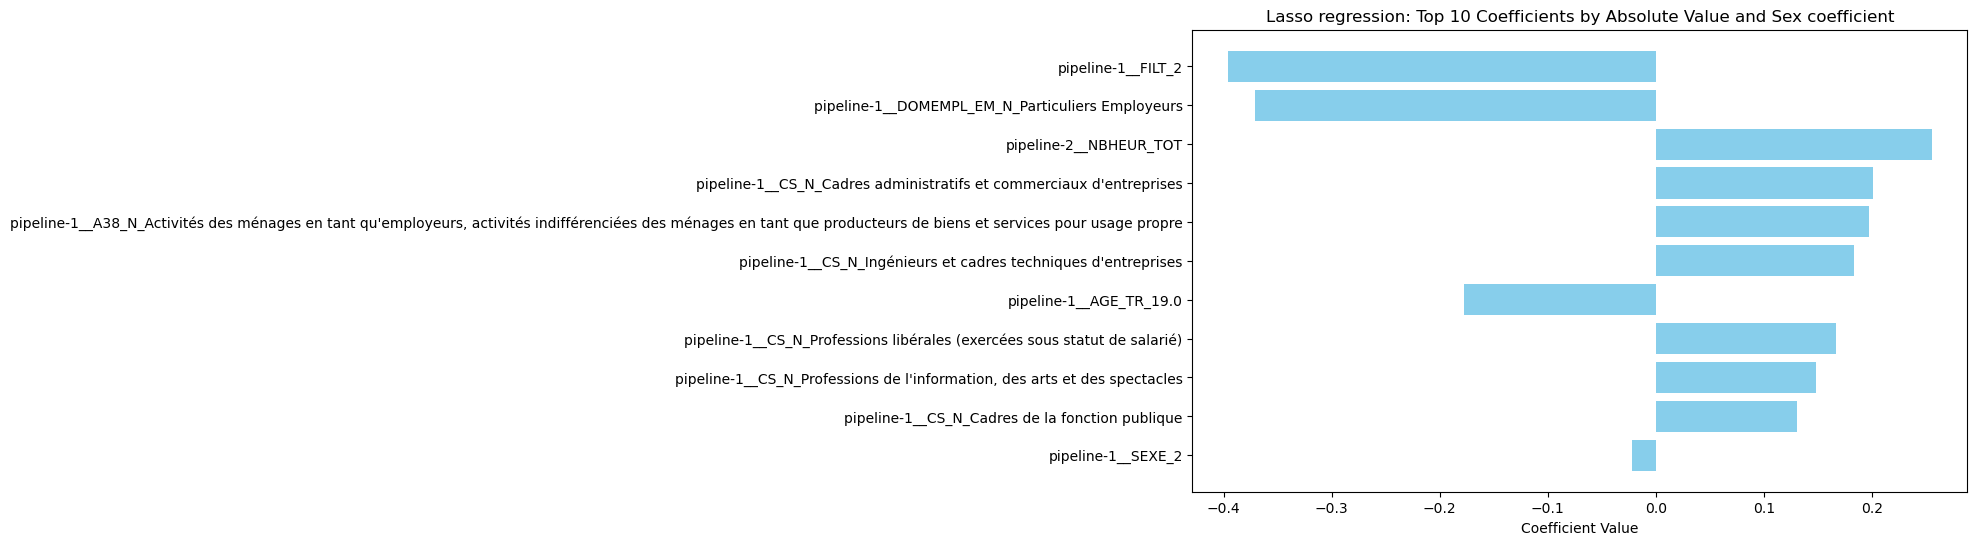

In [30]:
# Plot the top 10 coefficients
plt.figure(figsize=(10, 6))
plt.barh(top_10_with_specific_row.index, top_10_with_specific_row["Coefficients importance"], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Lasso regression: Top 10 Coefficients by Absolute Value and Sex coefficient')
plt.gca().invert_yaxis()  # To display the greatest coefficient at the top
plt.show()


In [31]:
# Then we check the quality of the predictions.

mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} €/year",
    "MedAE on testing set": f"{mae_test:.2f} €/year",
}


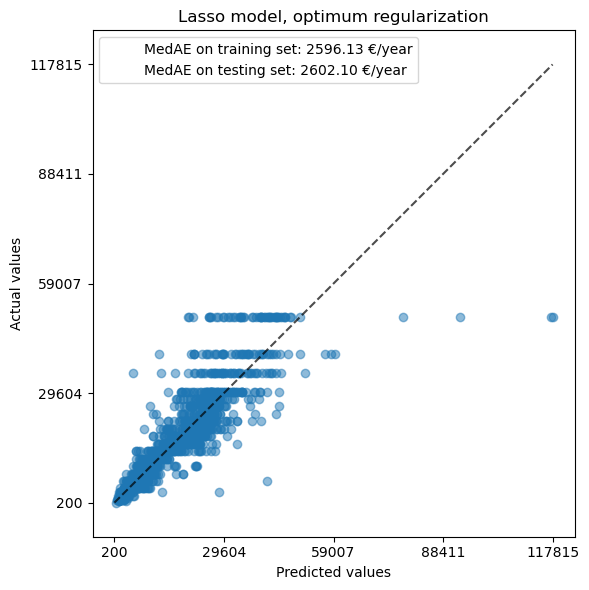

In [32]:
_, ax = plt.subplots(figsize=(6, 6))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Lasso model, optimum regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

## si on arrive à avoir le temps de CV le lasso

In [39]:
alphas = alpha_cv_lasso
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Lasso(alpha=alphas),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)

In [ ]:
# It is important to keep in mind that the coefficients that have been
# dropped may still be related to the outcome by themselves: the model
# chose to suppress them because they bring little or no additional
# information on top of the other features. Additionally, this selection
# is unstable for correlated features, and should be interpreted with
# caution.
#
# Indeed, we can check the variability of the coefficients across folds.


cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

## Then, we try the Lasso with the variables selected by the DAG

We consider less variables because we remove the "post-treatment" variables. Variables such as the time worked in a year or the socio-professionnal category depend heavily on gender. 

In [ ]:
target = ['WAGE']
numerical_columns = [
    'DATDEB', 'DATFIN', #date début et fin de rémunération par rapport au 01/01
     'AGE', #age en années
    #'DUREE', #durée de paie en jours
     # 'NBHEUR', 'NBHEUR_TOT', #nombre d'heures salariées total (quelle diff?)
    #'WAGE', #transformation of TRNNETO
    #'UNEMP' #transformation of TRALCHT
]

categorical_columns = [
    #'A6', 'A17', 'A38' #activité en nomenclature agrégrée
    #'CPFD', #temps complet ou partiel
    #DEPR', 'DEPT', #département résidence et travail
    #'DOMEMPL', 'DOMEMPL_EM', #domaine de l'emploi et l'établissement d'affectation/employeur
    
    #'FILT', #indic poste annexe 2 ou non-annexe 1 (seuils rémunération volume)
    #'REGR', 'REGT', #région de résidence et de travail
    'SEXE', #1 homme 2 femme
    #'PCS', #PCS-ESE
    #'TYP_EMPLOI', #ordinaire, apprenti, autre
    #'CONV_COLL', #convention collective
  
    #'TRNNETO', #rémunération nette globale en tranches -> à passer en numérique ?
    #'TRALCHT', #total des indémnités de chômage, en tranches -> passage en numérique ?
    'TREFF', #tranche d'effectif : de 0 à 250+ postes
    #'CONT_TRAV', #contrat de travail : APP apprentissage, TOA occasionnel ou à l'acte, TTP intérim, AUTre
    #'CS', #CSP mais code plus simple 
    'AGE_TR', #age en tranches quadriennales
    #'DATDEB_TR','DATFIN_TR', #dates début et fin rémunération en tranches
    #'DUREE_TR', #durée de paie exprimée en jours en tranches mensuelles
    'DOMEMPL_EM_N', 'DOMEMPL_N', #'REGR_N',
       #'REGT_N',# 'CS_N', 
    #'DEPR_N', 
    'DEPT_N',#'A38_N' #les variables renommées avec les labels correspondants aux codes
]

all_columns = numerical_columns + categorical_columns

In [ ]:
X = base[all_columns]
X.describe(include="all")
base['TARGET'] = base[target]
base.loc[base['TARGET'] == 0, 'TARGET'] = 1
y = base['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
preprocessor = make_column_transformer(
    # For categorical columns: impute missing values with the most frequent value and apply OneHotEncoding
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop="if_binary")), categorical_columns),
    
    # For numerical columns: impute missing values with the median and apply StandardScaler
    (make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), numerical_columns)
)

In [ ]:
alphas = np.logspace(-5, 5, 11)
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(alphas=alphas, max_iter=10000, n_jobs=-1),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)

In [ ]:
model.fit(X_train, y_train)

In [ ]:
alpha_cv_lasso = model[-1].regressor_.alpha_
alpha_cv_lasso

In [ ]:
feature_names = model[:-1].get_feature_names_out()
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Lasso model, normalized variables, DAG selection")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [ ]:
coefs["Coefficients importance"].value_counts()

In [ ]:
# Get the absolute value of coefficients
coefs["abs_coefs"] = coefs["Coefficients importance"].abs()

# Sort the coefficients by absolute value in descending order
coefs_sorted = coefs.sort_values(by='abs_coefs', ascending=False)

# Select the top 10 greatest coefficients in absolute value
top_10 = coefs_sorted.head(10)

specific_row = coefs[coefs.index == 'pipeline-1__SEXE_2']
top_10_with_specific_row = pd.concat([top_10, specific_row], axis=0)

# Re-sort if needed (optional), in case the specific row's coefficient value was smaller than the current top 10
top_10_with_specific_row = top_10_with_specific_row.sort_values(by='abs_coefs', ascending=False)
top_10_with_specific_row

In [ ]:
# Plot the top 10 coefficients
plt.figure(figsize=(10, 6))
plt.barh(top_10_with_specific_row.index, top_10_with_specific_row["Coefficients importance"], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Lasso regression: Top 10 Coefficients by Absolute Value and Sex coefficient')
plt.gca().invert_yaxis()  # To display the greatest coefficient at the top
plt.show()

The coefficient of Sex is more important than when we were controlling for occupation and time worked because we are interested in the global causal effect. 
Nevertheless, it is still less important than other variables such as age of the department. 

In [ ]:
# Then we check the quality of the predictions.

mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} €/year",
    "MedAE on testing set": f"{mae_test:.2f} €/year",
}


In [ ]:
_, ax = plt.subplots(figsize=(6, 6))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Lasso model, optimum regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

Removing variables makes the predictions less precise, the median absolute error is larger. 

In [ ]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

## retenter random forest ?

## tenter Ridge removing highly correlated features and doing CV

In [ ]:
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-10, 10, 21)  # alpha values to be chosen from by cross-validation
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=alphas),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)
model.fit(X_train, y_train)